In [12]:
import torch
import torch.nn as nn

from models import scribbler, discriminator, texturegan, localDiscriminator
import torch.optim as optim
from torch.autograd import Variable

import sys, os
from skimage import color
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import visdom
from IPython.display import display
import torchvision.models as models
from dataloader import imfol
from torch.utils.data.sampler import SequentialSampler

from torch.utils.data import DataLoader
from dataloader.imfol import ImageFolder, make_dataset

from utils import transforms as custom_transforms
from utils.visualize import vis_patch, vis_image
from models import scribbler, discriminator, define_G, weights_init, scribbler_dilate_128
import argparser

In [13]:
import argparse

def parse_arguments(argv):
    parser = argparse.ArgumentParser()

    ###############added options#######################################
    parser.add_argument('-lr', '--learning_rate', default=1e-5, type=float,
                        help='Learning rate for the generator')
    parser.add_argument('-lrd', '--learning_rate_D', default=1e-4, type=float,
                        help='Learning rate for the discriminator')

    parser.add_argument('--gan', default='lsgan', type=str, choices=['dcgan', 'lsgan', 'wgan', 'improved wgan'],
                        help='dcgan|lsgan|wgan|improved wgan')  # todo wgan/improved wgan

    parser.add_argument('--model', default='scribbler', type=str, choices=['scribbler', 'pix2pix','scribbler_dilate_128'],
                        help='scribbler|pix2pix')

    parser.add_argument('--num_epoch', default=1, type=int,
                        help='texture|scribbler')

    parser.add_argument('--visualize_every', default=10, type=int,
                        help='no. iteration to visualize the results')

    # all the weights ratio, might wanna make them sum to one
    parser.add_argument('--feature_weight', default=100, type=float,
                        help='weight ratio for feature loss')
    parser.add_argument('--pixel_weight_l', default=400, type=float,
                        help='weight ratio for pixel loss for l channel')
    parser.add_argument('--pixel_weight_ab', default=800, type=float,
                        help='weight ratio for pixel loss for ab channel')
    parser.add_argument('--pixel_weight_rgb', default=800, type=float,
                        help='weight ratio for pixel loss for ab channel')

    parser.add_argument('--discriminator_weight', default=2e1, type=float,
                        help='weight ratio for the discriminator loss')
    parser.add_argument('--style_weight', default=1, type=float,
                        help='weight ratio for the texture loss')

    # parser.add_argument('--gpu', default=[0], type=int, nargs='+',
    #                     help='List of GPU IDs to use')  # TODO support cpu
    parser.add_argument('--gpu', default=2, type=int, help="GPU ID")

    parser.add_argument('--display_port', default=7779, type=int,
                        help='port for displaying on visdom (need to match with visdom currently open port)')

    parser.add_argument('--data_path', default='/home/psangkloy3/training_shoes_pretrain/', type=str,
                        help='path to the data directory, expect train_skg, train_img, val_skg, val_img')

    parser.add_argument('--save_dir', default='/home/psangkloy3/shoes_best_models/', type=str,
                        help='path to save the model')

    parser.add_argument('--load_dir', default='/home/psangkloy3/shoes_best_models/', type=str,
                        help='path to save the model')

    parser.add_argument('--save_every', default=1000, type=int,
                        help='no. iteration to save the models')

    parser.add_argument('--load', default=0, type=int,
                        help='load generator and discrminator from iteration n')
    parser.add_argument('--load_D', default=0, type=int,
                        help='load discriminator from iteration n, priority over load')

    parser.add_argument('--image_size', default=128, type=int,
                        help='Training images size, after cropping')
    parser.add_argument('--resize_max', default=1, type=float,
                        help='max resize, ratio of the original image, max value is 1')
    parser.add_argument('--resize_min', default=0.6, type=float,
                        help='min resize, ratio of the original image, min value 0')
    parser.add_argument('--patch_size_min', default=20, type=int,
                        help='minumum texture patch size')
    parser.add_argument('--patch_size_max', default=40, type=int,
                        help='max texture patch size')

    parser.add_argument('--batch_size', default=32, type=int, help="Training batch size")

    parser.add_argument('--num_input_texture_patch', default=2,type=int)

    parser.add_argument('--local_texture_size', default=50, type=int,
                        help='use local texture loss instead of global, set -1 to use global')
    parser.add_argument('--color_space', default='lab', type=str, choices=['lab', 'rgb'],
                        help='lab|rgb')

    parser.add_argument('--threshold_D_max', default=0.8, type=int,
                        help='stop updating D when accuracy is over max')

    parser.add_argument('--content_layers', default='relu4_2', type=str,
                        help='Layer to attach content loss.')
    parser.add_argument('--style_layers', default='relu3_2, relu4_2', type=str,
                        help='Layer to attach content loss.')

    parser.add_argument('--use_segmentation_patch', default=True, type=bool,
                        help='whether or not to inject noise into the network')

    parser.add_argument('--input_texture_patch', default='dtd_texture', type=str,
                        choices=['original_image', 'dtd_texture'],
                        help='whether or not to inject noise into the network')

    ############################################################################
    ############################################################################
    ############TODO: TO ADD #################################################################
    parser.add_argument('--tv_weight', default=1, type=float,
                        help='weight ratio for total variation loss')

    parser.add_argument('--mode', default='texture', type=str, choices=['texture', 'scribbler'],
                        help='texture|scribbler')

    parser.add_argument('--crop', default='random', type=str, choices=['random', 'center'],
                        help='random|center')

    parser.add_argument('--contrast', default=True, type=bool,
                        help='randomly adjusting contrast on sketch')

    parser.add_argument('--occlude', default=False, type=bool,
                        help='randomly occlude part of the sketch')

    parser.add_argument('--checkpoints_path', default='data/', type=str,
                        help='output directory for results and models')

    parser.add_argument('--noise_gen', default=False, type=bool,
                        help='whether or not to inject noise into the network')

    parser.add_argument('--absolute_load', default='', type=str,
                        help='load saved generator model from absolute location')

    ##################################################################################################################################

    return parser.parse_args(argv)


In [14]:
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
%matplotlib inline

In [15]:
import warnings
warnings.filterwarnings('ignore')

### Load Val Data

In [20]:
command = ' python main.py --display_port 7778 --load 0 --load_D 0 --load_epoch 129 --gpu 3 --model scribbler --feature_weight 10 --pixel_weight_ab 10000 --pixel_weight_l 10000 --style_weight 0 --discriminator_weight 10 --discriminator_local_weight 0 --learning_rate 1e-2 --learning_rate_D 1e-4 --load_dir /home/wendy/scribbler_models_handbags_DTD_6 --save_dir /home/wendy/scribbler_models_handbags_DTD_6 --data_path /home/wxian3/training_handbags_pretrain/ --batch_size 45 --save_every 500 --num_epoch 100000 --input_texture_patch dtd_texture --loss_texture dtd_texture --local_texture_size 50 --num_input_texture_patch 6 --num_local_texture_patch 2'

In [21]:
args = parse_arguments(command.split())

usage: __main__.py [-h] [-lr LEARNING_RATE] [-lrd LEARNING_RATE_D]
                   [--gan {dcgan,lsgan,wgan,improved wgan}]
                   [--model {scribbler,pix2pix,scribbler_dilate_128}]
                   [--num_epoch NUM_EPOCH] [--visualize_every VISUALIZE_EVERY]
                   [--feature_weight FEATURE_WEIGHT]
                   [--pixel_weight_l PIXEL_WEIGHT_L]
                   [--pixel_weight_ab PIXEL_WEIGHT_AB]
                   [--pixel_weight_rgb PIXEL_WEIGHT_RGB]
                   [--discriminator_weight DISCRIMINATOR_WEIGHT]
                   [--style_weight STYLE_WEIGHT] [--gpu GPU]
                   [--display_port DISPLAY_PORT] [--data_path DATA_PATH]
                   [--save_dir SAVE_DIR] [--load_dir LOAD_DIR]
                   [--save_every SAVE_EVERY] [--load LOAD] [--load_D LOAD_D]
                   [--image_size IMAGE_SIZE] [--resize_max RESIZE_MAX]
                   [--resize_min RESIZE_MIN] [--patch_size_min PATCH_SIZE_MIN]
                 

SystemExit: 2

In [27]:
if args.color_space == 'lab':
            transform = custom_transforms.Compose([
                custom_transforms.RandomSizedCrop(args.image_size,args.resize_min,args.resize_max),
                custom_transforms.RandomHorizontalFlip(),
                custom_transforms.toLAB(),
                custom_transforms.toTensor()
            ])

elif args.color_space == 'rgb':
            transform = custom_transforms.Compose([
                custom_transforms.RandomSizedCrop(args.image_size,args.resize_min,args.resize_max),
                custom_transforms.RandomHorizontalFlip(),
                custom_transforms.toRGB('RGB'),
                custom_transforms.toTensor()
            ])
            args.pixel_weight_ab = args.pixel_weight_rgb
            args.pixel_weight_l = args.pixel_weight_rgb

In [28]:
val = imfol.make_dataset(args.data_path, 'val')

In [29]:
def save_network(model, network_label, epoch_label, gpu_id, save_dir):
    save_filename = '%s_net_%s.pth' % (epoch_label, network_label)
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    save_path = os.path.join(save_dir, save_filename)
    torch.save(model.cpu().state_dict(), save_path)
    model.cuda(device_id=gpu_id)


def load_network(model, network_label, epoch_label,save_dir):
    save_filename = '%s_net_%s.pth' % (epoch_label, network_label)
    save_path = os.path.join(save_dir, save_filename)
    model.load_state_dict(torch.load(save_path))

In [30]:
valDset = ImageFolder('val', args.data_path, transform)
val_display_size = args.batch_size
indices = torch.randperm(len(valDset))
val_display_sampler = SequentialSampler(indices[:val_display_size])
valLoader = DataLoader(dataset=valDset, batch_size=val_display_size,sampler=val_display_sampler)

### Load Pretrained model

In [31]:
        if args.gan =='lsgan':
            sigmoid_flag = 0 

        if args.model == 'scribbler':
            netG = scribbler.Scribbler(5, 3, 32)
        elif args.model == 'texturegan':
            netG = texturegan.TextureGAN(5, 3, 32)
        elif args.model == 'pix2pix':
            netG = define_G(5, 3, 32)
        elif args.model == 'scribbler_dilate_128':
            netG = scribbler_dilate_128.ScribblerDilate128(5, 3, 32)
        else:
            print(args.model + ' not support. Using Scribbler model')
            netG = scribbler.Scribbler(5, 3, 32)

        if args.color_space == 'lab':
            netD = discriminator.Discriminator(1,32,sigmoid_flag)
        elif args.color_space == 'rgb':
            netD = discriminator.Discriminator(3,32,sigmoid_flag)
        feat_model=models.vgg19(pretrained=True)
        if args.load == -1:
            netG.apply(weights_init)
        else:

            load_network(netG,'G',args.load,args.load_dir)
            print('Loaded G from itr:' + str(args.load))
        if args.load_D == -1:
            netD.apply(weights_init)  
        else:
            load_network(netD,'D',args.load_D,args.load_dir)
            print('Loaded D from itr:' + str(args.load_D))

        if args.gan =='lsgan':
            criterion_gan = nn.MSELoss()
        elif args.gan =='dcgan':
            criterion_gan = nn.BCELoss()
        else:
            raise Warning("Undefined GAN type. Defaulting to LSGAN")
            criterion_gan = nn.MSELoss()

Loaded G from itr:0
Loaded D from itr:0


In [32]:
from train import gen_input, rand_between

In [33]:
def gen_input_exact(img, skg, seg, xcenter=64, ycenter=64, crop_size=60, num_patch=1):
    #generate input skg with random patch from img
    #input img,skg [bsx3xwxh], xcenter,ycenter, size 
    #output bsx5xwxh
    MAX_COUNT = 10000
    bs,c,w,h = img.size()
    results = torch.Tensor(bs,5,w,h)
    texture_info = []

    #text_info.append([xcenter,ycenter,crop_size])    
    seg = seg/torch.max(seg)
    counter = 0
    for i in range(bs):
        counter=0
        ini_texture = torch.ones(img[0].size())*(1)
        ini_mask =  torch.ones((1,w,h))*(-1)
        temp_info = []
        for j in range(num_patch):
            xstart = max(int(xcenter-crop_size/2), 0)
            ystart = max(int(ycenter-crop_size/2), 0)
            xend = min(int(xcenter + crop_size/2), w)
            yend = min(int(ycenter + crop_size/2), h)
            patch = seg[i, xstart:xend, ystart:yend]
            sizem = torch.ones(patch.size())            

            temp_info.append([xcenter, ycenter, crop_size])
            res = gen_input(img[i], skg[i], ini_texture, ini_mask, xcenter, ycenter, crop_size)
          
            ini_texture = res[1:4,:,:]
            
        texture_info.append(temp_info)
        results[i,:,:,:] = res
    return results, texture_info


### Test inputs

In [34]:
data = valLoader.__iter__().__next__()

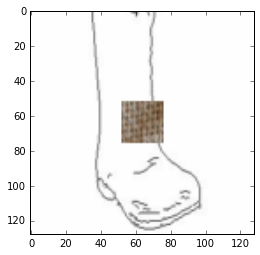

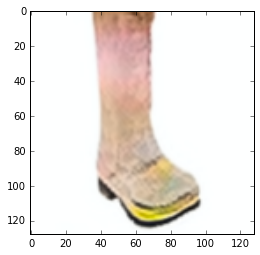

In [35]:
@interact(x=[0,25],xcenter=[0,128],ycenter=[0,128],size=[10,100])
def move_patch(x,xcenter,ycenter,size):
    img, skg, seg,txt = data 
    img=custom_transforms.normalize_lab(img)
    skg=custom_transforms.normalize_lab(skg)
    txt=custom_transforms.normalize_lab(txt)
    
    if not args.use_segmentation_patch:
        seg.fill_(1)
    if args.input_texture_patch == 'original_image':
        inp, texture_loc = gen_input_exact(img, skg, seg[:,0,:,:], xcenter,ycenter,size)
    elif args.input_texture_patch == 'dtd_texture':
        inp, texture_loc = gen_input_exact(txt, skg, seg[:,0,:,:], xcenter,ycenter,size)
                            
                            
    img=img.cuda()
    skg=skg.cuda()
    seg=seg.cuda()
    txt = txt.cuda()
    inp = inp.cuda()
    
    if args.input_texture_patch == 'original_image':
        inp_img = vis_patch(custom_transforms.denormalize_lab(img.cpu()),
                                            custom_transforms.denormalize_lab(skg.cpu()),
                                            texture_loc,
                                            args.color_space)
    elif args.input_texture_patch == 'dtd_texture':
        inp_img = vis_patch(custom_transforms.denormalize_lab(txt.cpu()),
                                            custom_transforms.denormalize_lab(skg.cpu()),
                                            texture_loc,
                                            args.color_space)
        tar_img = vis_image(custom_transforms.denormalize_lab(img.cpu()),
                                            args.color_space)
    plt.figure(1)    
    plt.imshow(np.transpose(inp_img[x],(1, 2, 0)))
    
    input_stack = torch.FloatTensor()
    input_stack = input_stack.cuda()
    input_stack.resize_as_(inp.float()).copy_(inp)

    inputv = Variable(input_stack)
    netG.cuda()
    outputG = netG(inputv)
    
    plt.figure(2)                    
    out_img = vis_image(custom_transforms.denormalize_lab(outputG.data.double().cpu()), args.color_space)
    plt.imshow(np.transpose(out_img[x],(1, 2, 0)))